SETUP

In [1]:
!pip -q install gensim wordcloud nltk scikit-learn matplotlib pandas
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

IMPORTS

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 140


20 Newsgroups

In [4]:
dataset = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))
docs_raw = dataset.data
len(docs_raw)


18846

PREPROCESAMIENTO

In [5]:
stop_en = set(stopwords.words('english'))
pat = re.compile(r"[^a-zA-Z\s]+")

def clean_tokenize(text):
    t = text.lower()
    t = pat.sub(" ", t)
    toks = word_tokenize(t)
    toks = [w for w in toks if w not in stop_en and len(w) > 2]
    return toks

tokens = [clean_tokenize(doc) for doc in docs_raw]
sum(len(t) for t in tokens[:5])


341

EMBEDDINGS PROPIOS

In [6]:
w2v = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=2, workers=4, sg=1, epochs=10)

def doc_vec(tok_list):
    vecs = [w2v.wv[w] for w in tok_list if w in w2v.wv.key_to_index]
    if len(vecs) == 0:
        return np.zeros(w2v.vector_size, dtype=np.float32)
    return np.mean(vecs, axis=0)

X = np.vstack([doc_vec(t) for t in tokens])
X.shape


(18846, 100)

K-Means: codo + silhouette

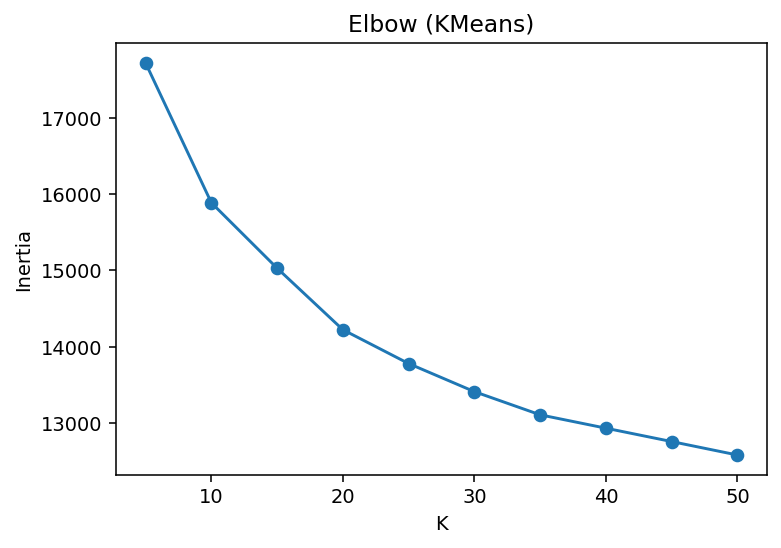

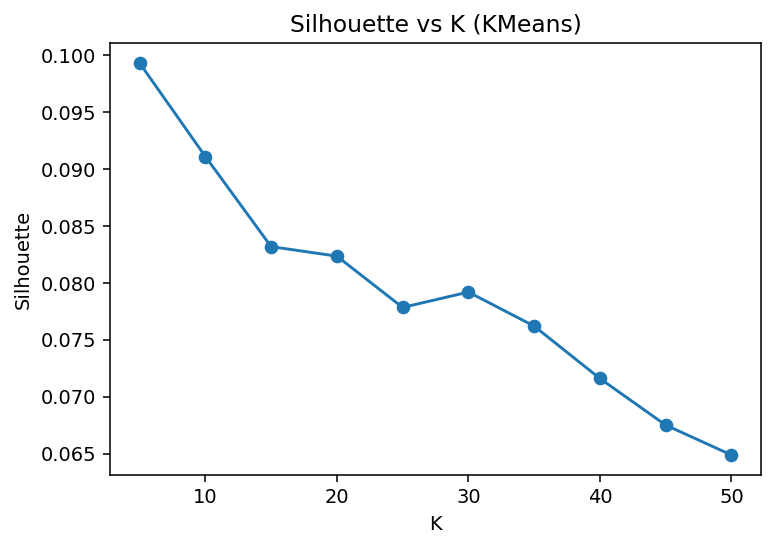

5

In [7]:
ks = list(range(5, 51, 5))
inertias, sil_ks = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)
    try:
        sil_ks.append(silhouette_score(X, km.labels_))
    except Exception:
        sil_ks.append(np.nan)

plt.plot(ks, inertias, marker='o')
plt.xlabel('K'); plt.ylabel('Inertia'); plt.title('Elbow (KMeans)')
plt.show()

plt.plot(ks, sil_ks, marker='o')
plt.xlabel('K'); plt.ylabel('Silhouette'); plt.title('Silhouette vs K (KMeans)')
plt.show()

valid_sil = [(k, s) for k, s in zip(ks, sil_ks) if not np.isnan(s)]
best_k = max(valid_sil, key=lambda x: x[1])[0] if len(valid_sil) else 20
best_k


K-Means final + métricas

In [8]:
kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42).fit(X)
kmeans_labels = kmeans.labels_

km_s = silhouette_score(X, kmeans_labels)
km_db = davies_bouldin_score(X, kmeans_labels)
km_ch = calinski_harabasz_score(X, kmeans_labels)

(km_s, km_db, km_ch, len(set(kmeans_labels)))


(np.float32(0.09929256),
 np.float64(2.3031926411860844),
 np.float32(1626.3745),
 5)

DBSCAN: mini grid de hiperparámetros

In [9]:
eps_vals = [0.3, 0.4, 0.5, 0.7, 0.9, 1.1]
min_samples_vals = [3, 5, 10]

def safe_metrics(X, labels):
    uniq = set(labels)
    if len([u for u in uniq if u != -1]) < 2:
        return np.nan, np.nan, np.nan
    try:
        s = silhouette_score(X, labels)
    except Exception:
        s = np.nan
    try:
        db = davies_bouldin_score(X, labels)
    except Exception:
        db = np.nan
    try:
        ch = calinski_harabasz_score(X, labels)
    except Exception:
        ch = np.nan
    return s, db, ch

grid = []
best = {'score': -np.inf, 'eps': None, 'ms': None, 'labels': None}
for eps in eps_vals:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
        labels = db.fit_predict(X)
        s, dbi, chi = safe_metrics(X, labels)
        grid.append({'eps': eps, 'min_samples': ms, 'silhouette': s, 'davies_bouldin': dbi, 'calinski_harabasz': chi,
                     'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                     'n_noise': int(np.sum(labels == -1))})
        if not np.isnan(s) and s > best['score'] and (len(set(labels)) - (1 if -1 in labels else 0)) > 1:
            best = {'score': s, 'eps': eps, 'ms': ms, 'labels': labels}

grid_df = pd.DataFrame(grid)
grid_df.sort_values('silhouette', ascending=False).head(10)


,eps,min_samples,silhouette,davies_bouldin,calinski_harabasz,n_clusters,n_noise
16,1.1,5,0.316892,5.245065,43.634293,3,988
15,1.1,3,0.250364,2.430109,39.701195,11,941
14,0.9,10,0.247334,6.309245,872.436707,2,2574
12,0.9,3,0.151899,1.907699,140.167923,16,2410
11,0.7,10,0.114719,4.987347,976.250061,2,7157
13,0.9,5,0.103080,2.884049,235.106293,8,2475
10,0.7,5,-0.019465,1.816146,147.121323,16,6781
9,0.7,3,-0.093729,1.414723,55.169510,48,6539
8,0.5,10,-0.095137,2.533547,509.235504,4,15156
1,0.3,5,-0.178818,1.010344,158.354431,11,18227


DBSCAN final + métricas

In [10]:
if best['labels'] is None:
    dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1).fit(X)
    db_labels = dbscan.labels_
    best_eps, best_ms = 0.5, 5
else:
    dbscan = DBSCAN(eps=best['eps'], min_samples=best['ms'], n_jobs=-1).fit(X)
    db_labels = dbscan.labels_
    best_eps, best_ms = best['eps'], best['ms']

db_s, db_db, db_ch = safe_metrics(X, db_labels)
((best_eps, best_ms), (db_s, db_db, db_ch),
 len(set(db_labels)) - (1 if -1 in set(db_labels) else 0))


((1.1, 5),
 (np.float32(0.31689194),
  np.float64(5.245065040195364),
  np.float32(43.634293)),
 3)

Visualizaciones 2D (t-SNE con fallback a PCA)

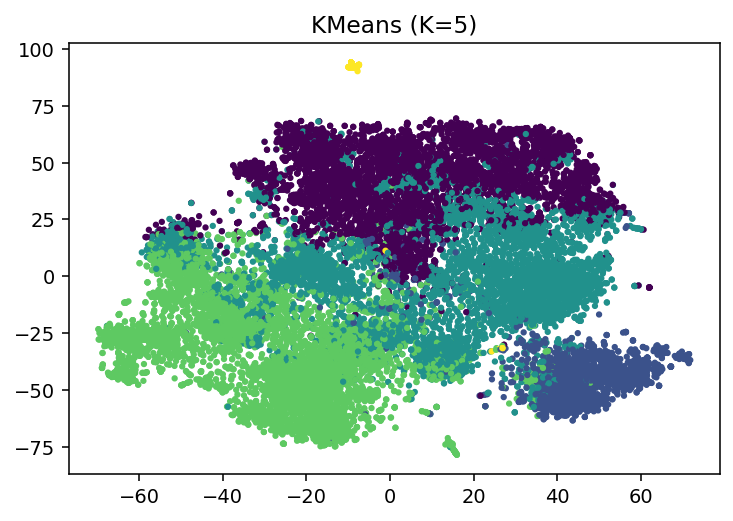

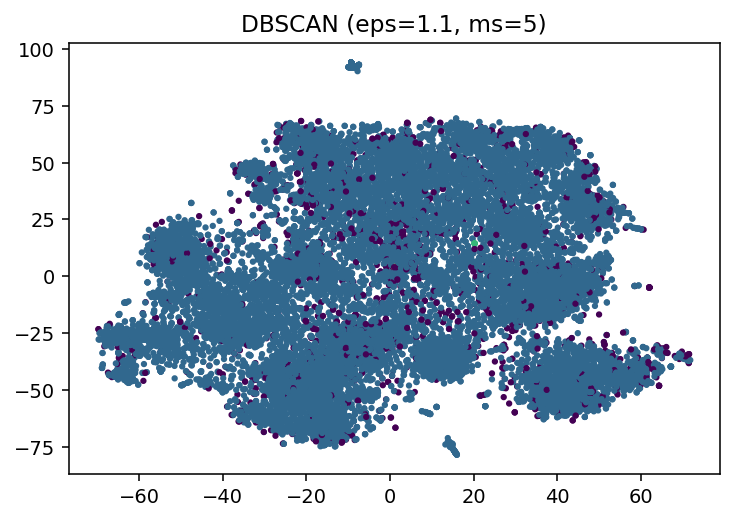

In [11]:
def reduce_2d(X):
    try:
        return TSNE(n_components=2, init='random', perplexity=30, learning_rate='auto', random_state=42).fit_transform(X)
    except Exception:
        return PCA(n_components=2, random_state=42).fit_transform(X)

X2d = reduce_2d(X)

def scatter_plot(X2, labels, title):
    plt.scatter(X2[:,0], X2[:,1], s=5, c=labels)
    plt.title(title)
    plt.show()

scatter_plot(X2d, kmeans_labels, f'KMeans (K={best_k})')
scatter_plot(X2d, db_labels, f'DBSCAN (eps={best_eps}, ms={best_ms})')


Nubes de palabras por cluster

KMeans wordclouds:


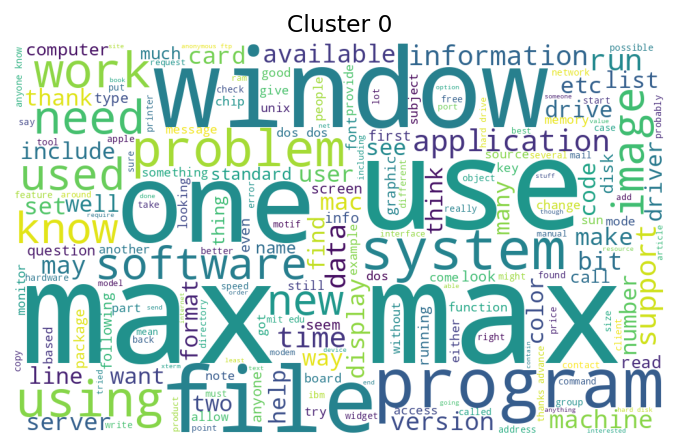

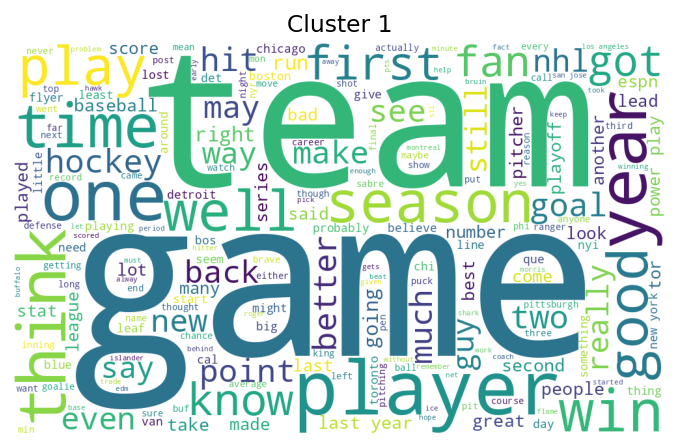

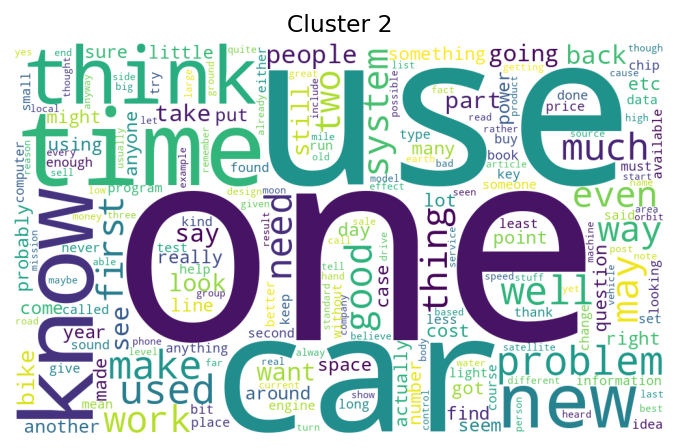

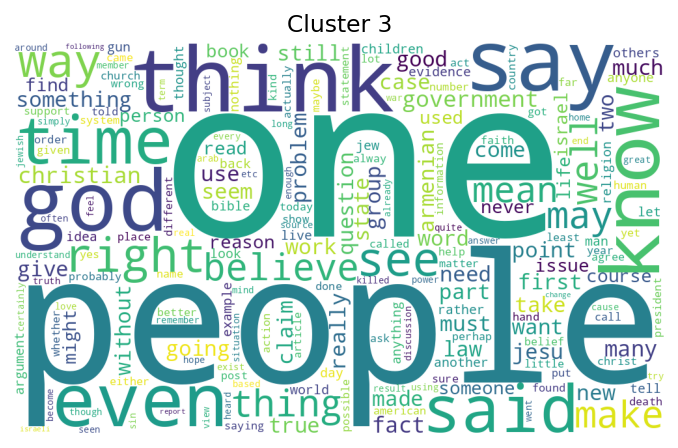

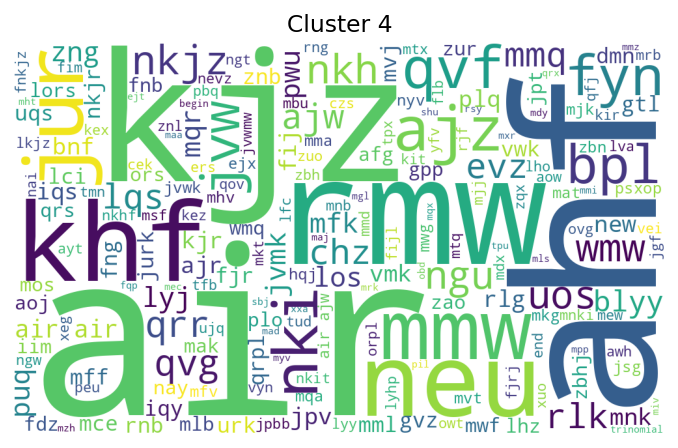

DBSCAN wordclouds:


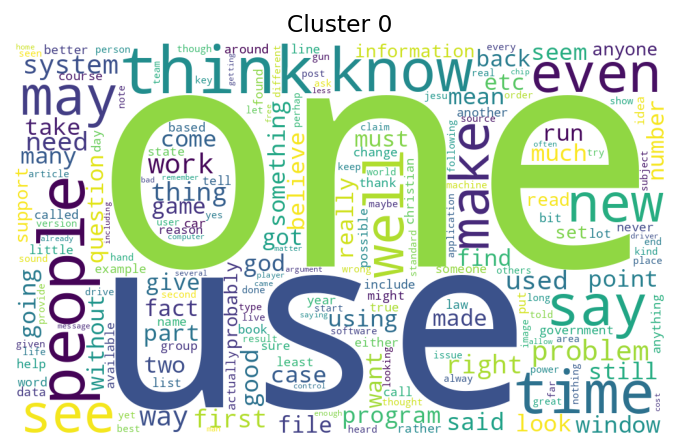

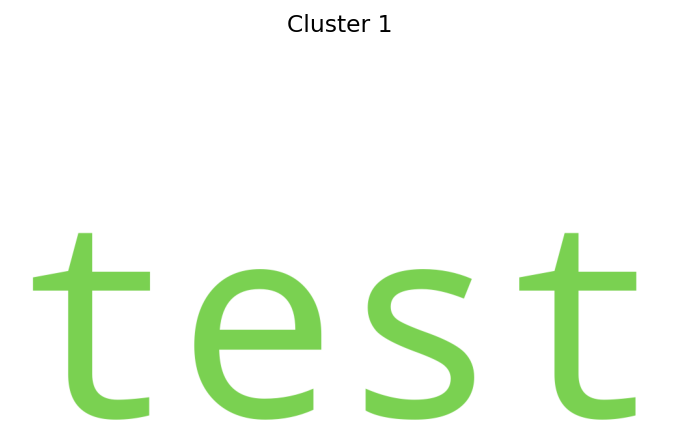

In [13]:
def wordclouds(labels, tokens, top=6):
    lbls = np.array(labels)
    unique = [l for l in sorted(set(lbls)) if l != -1]
    shown = 0
    for l in unique:
        idx = np.where(lbls == l)[0]
        words = []
        for i in idx:
            words.extend(tokens[i])
        text = " ".join(words)
        if not text.strip():
            continue
        wc = WordCloud(width=1000, height=600, background_color='white').generate(text)
        plt.imshow(wc); plt.axis('off'); plt.title(f'Cluster {l}'); plt.show()
        shown += 1
        if shown >= top:
            break

print("KMeans wordclouds:")
wordclouds(kmeans_labels, tokens, top=6)
print("DBSCAN wordclouds:")
wordclouds(db_labels, tokens, top=6)


Tabla comparativa

In [12]:
comp = pd.DataFrame([
    {'Modelo':'KMeans', 'Silhouette': km_s, 'DaviesBouldin': km_db, 'CalinskiHarabasz': km_ch, 'Clusters': len(set(kmeans_labels))},
    {'Modelo':'DBSCAN', 'Silhouette': db_s, 'DaviesBouldin': db_db, 'CalinskiHarabasz': db_ch, 'Clusters': len(set(db_labels)) - (1 if -1 in set(db_labels) else 0)}
])
comp


,Modelo,Silhouette,DaviesBouldin,CalinskiHarabasz,Clusters
0,KMeans,0.099293,2.303193,1626.374512,5
1,DBSCAN,0.316892,5.245065,43.634293,3


In [13]:
comp.to_csv('comparacion_metricas.csv', index=False)
grid_df.to_csv('dbscan_grid_search.csv', index=False)
print("Listo. CSVs guardados en el panel de archivos de Colab.")


Listo. CSVs guardados en el panel de archivos de Colab.
